In [1]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import Flatten, Conv2D, MaxPooling2D
from keras.losses import sparse_categorical_crossentropy, mse
from keras.optimizers import Adam
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
num_classes = 10
batch_size = 100
epochs = 10
stats = []

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

('x_train shape:', (60000, 28, 28, 1))
(60000, 'train samples')
(10000, 'test samples')


In [6]:
x = Input(shape=input_shape)
h = Conv2D(32, (3, 3), activation='relu')(x)
h = Conv2D(64, (3, 3), activation='relu')(h)
h = MaxPooling2D(pool_size=(2, 2))(h)
h = Dropout(0.25)(h)
h = Flatten()(h)
h = Dense(128, activation='relu')(h)
h = Dropout(0.5)(h)
p = Dense(num_classes, activation='softmax')(h)
b = Dense(1, activation='sigmoid')(h)
a = Input(shape=(1,))
model = Model([x, a], [p, b])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 26, 26, 32)    320         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 24, 24, 64)    18496       conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 12, 12, 64)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [7]:
def policy_gradient_loss(y_true, y_pred):
    return a * sparse_categorical_crossentropy(y_true, y_pred)[:, np.newaxis]

model.compile(loss=[policy_gradient_loss, 'binary_crossentropy'],
              optimizer=Adam(lr=0.001))

In [8]:
for n in range(epochs):
    for i in range(0, x_train.shape[0], batch_size):
        x_batch = x_train[i:(i + batch_size)]
        y_batch = y_train[i:(i + batch_size)]

        # predict class probabilities
        a = np.zeros((x_batch.shape[0], 1))
        y_preds, baselines = model.predict([x_batch, a])

        # sample from those probabilities
        y_sample = np.empty((batch_size,), dtype=np.integer)
        for j, p in enumerate(y_preds):
            y_sample[j] = np.random.choice(num_classes, p=p)

        # calculate accuracy for logging
        y_preds = np.argmax(y_preds, axis=1)
        accuracy = np.mean(y_preds == y_batch)
        baseline = np.mean(baselines)

        # calculate reward and advantage, update baseline
        rewards = (y_sample == y_batch)[:, np.newaxis]
        advantages = rewards - baselines

        # train with samples as targets and advantage as sample weight
        losses = model.train_on_batch([x_batch, advantages], [y_sample, rewards])

        # log statistics
        stats.append(losses + [accuracy, baseline])
        print(i, losses, accuracy, baseline)

(0, [-0.18496794, -0.90333283, 0.71836489], 0.050000000000000003, 0.51611656)
(100, [-0.0084668398, -0.46801037, 0.45954353], 0.040000000000000001, 0.3048746)
(200, [0.32808694, -0.06515947, 0.39324641], 0.13, 0.13628682)
(300, [0.74918705, 0.24682336, 0.50236368], 0.050000000000000003, 0.055237465)
(400, [0.41230184, 0.078827135, 0.3334747], 0.13, 0.052882146)
(500, [0.28032565, 0.035286169, 0.24503948], 0.22, 0.056501411)
(600, [0.29863235, 0.0083810631, 0.29025128], 0.16, 0.064261548)
(700, [0.27850252, 0.020041451, 0.25846106], 0.14000000000000001, 0.066541061)
(800, [0.092073999, -0.10468223, 0.19675623], 0.11, 0.083834983)
(900, [0.4922052, 0.097647503, 0.39455771], 0.11, 0.085646585)
(1000, [0.24636021, -0.08490441, 0.33126462], 0.22, 0.11235858)
(1100, [0.35104823, -0.0092617897, 0.36031002], 0.17000000000000001, 0.1130387)
(1200, [0.41628, 0.030339187, 0.38594082], 0.17000000000000001, 0.10879678)
(1300, [0.4313949, 0.014744963, 0.41664994], 0.23000000000000001, 0.12371318)
(1

(11000, [-0.073092192, -0.37567168, 0.30257949], 0.87, 0.86142927)
(11100, [-0.10659465, -0.59153622, 0.48494157], 0.81999999999999995, 0.82207346)
(11200, [-0.22128153, -0.77000511, 0.54872358], 0.77000000000000002, 0.83372271)
(11300, [0.017402589, -0.4666484, 0.48405099], 0.80000000000000004, 0.81281799)
(11400, [0.4158096, 0.062522896, 0.35328671], 0.82999999999999996, 0.79157615)
(11500, [-0.11085641, -0.66070831, 0.54985189], 0.76000000000000001, 0.80730993)
(11600, [-0.53539085, -1.1845309, 0.64914], 0.71999999999999997, 0.77401078)
(11700, [0.63958287, 0.049677946, 0.5899049], 0.76000000000000001, 0.79457903)
(11800, [0.38398445, -0.0053773476, 0.3893618], 0.81000000000000005, 0.72567642)
(11900, [0.12266418, -0.33354801, 0.45621219], 0.71999999999999997, 0.70335436)
(12000, [0.39477456, -0.1077515, 0.50252604], 0.84999999999999998, 0.72022736)
(12100, [0.020577997, -0.45666832, 0.47724631], 0.82999999999999996, 0.7528457)
(12200, [-0.08938846, -0.51926714, 0.42987868], 0.80000

(22000, [0.56671923, 0.31756547, 0.24915376], 0.93999999999999995, 0.87488526)
(22100, [-0.25872433, -0.8327471, 0.57402277], 0.81000000000000005, 0.86294729)
(22200, [-0.59348536, -1.0209899, 0.42750457], 0.85999999999999999, 0.91308379)
(22300, [-0.34524134, -0.62228847, 0.27704713], 0.93999999999999995, 0.9242245)
(22400, [-0.13844657, -0.7460835, 0.60763693], 0.79000000000000004, 0.9166609)
(22500, [-1.1904104, -2.0377724, 0.84736198], 0.71999999999999997, 0.91749853)
(22600, [-0.39568311, -0.91596985, 0.52028674], 0.82999999999999996, 0.90604997)
(22700, [0.12970382, -0.26635274, 0.39605656], 0.85999999999999999, 0.88883448)
(22800, [-0.10670394, -0.49340767, 0.38670373], 0.85999999999999999, 0.86619657)
(22900, [0.4029862, 0.047996912, 0.35498929], 0.93000000000000005, 0.84297216)
(23000, [0.74858844, 0.40607312, 0.34251529], 0.92000000000000004, 0.80521357)
(23100, [0.77397859, 0.44467464, 0.32930398], 0.93000000000000005, 0.81078094)
(23200, [0.79468524, 0.4826588, 0.31202641],

(32500, [0.082856297, -0.16585848, 0.24871477], 0.94999999999999996, 0.94204384)
(32600, [-0.041597486, -0.22992386, 0.18832637], 0.95999999999999996, 0.93691796)
(32700, [-0.43333909, -0.80366379, 0.3703247], 0.89000000000000001, 0.93108612)
(32800, [0.11406142, -0.13840136, 0.25246277], 0.94999999999999996, 0.94561636)
(32900, [0.25386977, 0.044481877, 0.2093879], 0.93999999999999995, 0.93726367)
(33000, [0.048893631, -0.22392103, 0.27281466], 0.93000000000000005, 0.93152273)
(33100, [-0.25846654, -0.55836165, 0.29989511], 0.93000000000000005, 0.93920523)
(33200, [0.0010168254, -0.33214265, 0.33315948], 0.90000000000000002, 0.93204027)
(33300, [0.071040154, -0.32114756, 0.39218771], 0.89000000000000001, 0.9317643)
(33400, [0.029056117, -0.24059601, 0.26965213], 0.92000000000000004, 0.92320085)
(33500, [-0.12889647, -0.47359252, 0.34469604], 0.88, 0.91793501)
(33600, [-0.011333585, -0.30448031, 0.29314673], 0.92000000000000004, 0.91625857)
(33700, [0.39467433, 0.1154106, 0.27926373], 

(43000, [0.13210717, -0.28983074, 0.42193791], 0.89000000000000001, 0.89629847)
(43100, [0.43526509, 0.19242641, 0.24283868], 0.94999999999999996, 0.91007155)
(43200, [0.02724573, -0.22766989, 0.25491562], 0.91000000000000003, 0.91786903)
(43300, [0.12151784, -0.063975975, 0.18549381], 0.96999999999999997, 0.9310692)
(43400, [0.30641034, 0.11486074, 0.1915496], 0.96999999999999997, 0.93472654)
(43500, [-0.38612312, -0.7580899, 0.37196678], 0.91000000000000003, 0.93969947)
(43600, [0.093973234, -0.060193006, 0.15416624], 0.96999999999999997, 0.94898397)
(43700, [-0.11856887, -0.38523248, 0.26666361], 0.92000000000000004, 0.94826394)
(43800, [-0.32360521, -0.63245493, 0.30884972], 0.93000000000000005, 0.95228922)
(43900, [-0.31597689, -0.58705038, 0.27107349], 0.92000000000000004, 0.94754386)
(44000, [-0.28861862, -0.56201494, 0.27339631], 0.90000000000000002, 0.950167)
(44100, [-0.46445882, -0.9137361, 0.44927728], 0.85999999999999999, 0.94582176)
(44200, [-0.32127434, -0.80196661, 0.48

(53500, [-0.013975561, -0.29328507, 0.27930951], 0.89000000000000001, 0.90579951)
(53600, [0.30734617, 0.09356676, 0.2137794], 0.93999999999999995, 0.91009539)
(53700, [-0.0039587617, -0.20845541, 0.20449665], 0.95999999999999996, 0.92923433)
(53800, [0.27546605, 0.036686648, 0.23877941], 0.93999999999999995, 0.94133872)
(53900, [0.067201957, -0.21165009, 0.27885205], 0.93999999999999995, 0.93684149)
(54000, [0.24839836, -0.039959133, 0.2883575], 0.93000000000000005, 0.92316961)
(54100, [-0.011481196, -0.25167662, 0.24019542], 0.93999999999999995, 0.9515841)
(54200, [0.26789075, 0.15775163, 0.11013911], 0.96999999999999997, 0.95520568)
(54300, [-0.086168215, -0.28170884, 0.19554062], 0.94999999999999996, 0.95828736)
(54400, [0.18833411, 0.031822551, 0.15651156], 0.97999999999999998, 0.96597368)
(54500, [0.059996188, -0.16158083, 0.22157702], 0.93000000000000005, 0.96803749)
(54600, [0.045320593, -0.036630489, 0.081951082], 0.98999999999999999, 0.97563994)
(54700, [-0.015768453, -0.1140

(4000, [0.060942627, -0.099317186, 0.16025981], 0.95999999999999996, 0.95901847)
(4100, [0.14929503, -0.055307589, 0.20460263], 0.94999999999999996, 0.94484603)
(4200, [-0.19923028, -0.47940713, 0.28017685], 0.92000000000000004, 0.96829611)
(4300, [-0.10840055, -0.28250486, 0.1741043], 0.95999999999999996, 0.96158355)
(4400, [-0.044645548, -0.24214876, 0.19750321], 0.95999999999999996, 0.96470863)
(4500, [0.10143937, -0.13818589, 0.23962526], 0.93000000000000005, 0.96538526)
(4600, [-0.45654768, -0.79030663, 0.33375895], 0.91000000000000003, 0.96221304)
(4700, [-0.10708703, -0.32279909, 0.21571206], 0.94999999999999996, 0.95586258)
(4800, [-0.39876881, -0.61483979, 0.21607098], 0.93999999999999995, 0.94993109)
(4900, [0.15670907, -0.068739325, 0.2254484], 0.94999999999999996, 0.95692903)
(5000, [0.32505184, 0.16581298, 0.15923886], 0.95999999999999996, 0.9487651)
(5100, [-0.32906556, -0.66410744, 0.33504188], 0.87, 0.94700211)
(5200, [0.32400393, 0.16762353, 0.15638041], 0.969999999999

(14500, [-0.22359884, -0.57239789, 0.34879905], 0.91000000000000003, 0.94200087)
(14600, [-0.11592662, -0.41252726, 0.29660064], 0.89000000000000001, 0.89763379)
(14700, [0.14197682, -0.18909971, 0.33107653], 0.87, 0.89940977)
(14800, [0.011914253, -0.27915698, 0.29107124], 0.91000000000000003, 0.91580498)
(14900, [0.16401872, -0.034546833, 0.19856556], 0.95999999999999996, 0.94305861)
(15000, [0.17940325, 0.032086745, 0.1473165], 0.97999999999999998, 0.93870807)
(15100, [0.46224207, 0.16882385, 0.2934182], 0.91000000000000003, 0.93721205)
(15200, [-0.0090345144, -0.25988349, 0.25084898], 0.93999999999999995, 0.94816786)
(15300, [0.050454959, -0.16634139, 0.21679635], 0.93999999999999995, 0.95079851)
(15400, [0.26887563, 0.059802514, 0.20907311], 0.93999999999999995, 0.95347399)
(15500, [0.10041848, -0.12585555, 0.22627403], 0.93999999999999995, 0.95816803)
(15600, [0.18551333, -0.00087629049, 0.18638963], 0.95999999999999996, 0.96599221)
(15700, [-0.26204312, -0.61541635, 0.35337323],

(25000, [0.066273324, -0.087452315, 0.15372564], 0.95999999999999996, 0.96804166)
(25100, [-0.080686077, -0.23686986, 0.15618378], 0.95999999999999996, 0.97363973)
(25200, [-0.21629846, -0.52315718, 0.30685872], 0.93000000000000005, 0.97204745)
(25300, [-0.18658876, -0.3870042, 0.20041543], 0.95999999999999996, 0.97044015)
(25400, [0.083323039, -0.033033505, 0.11635654], 0.96999999999999997, 0.97260123)
(25500, [-0.28459936, -0.47000495, 0.1854056], 0.94999999999999996, 0.97851425)
(25600, [-0.42357504, -0.66797143, 0.2443964], 0.93999999999999995, 0.97876579)
(25700, [-0.012102596, -0.094358139, 0.082255542], 0.95999999999999996, 0.97894478)
(25800, [0.15167162, -0.011941715, 0.16361333], 0.95999999999999996, 0.97613263)
(25900, [-0.44454634, -0.66574281, 0.22119646], 0.93000000000000005, 0.97424608)
(26000, [0.015614323, -0.098155946, 0.11377027], 0.96999999999999997, 0.97520757)
(26100, [-0.045238584, -0.17165045, 0.12641187], 0.97999999999999998, 0.97298342)
(26200, [-0.056092829, 

(35500, [0.12698099, -0.010527913, 0.1375089], 0.97999999999999998, 0.95535117)
(35600, [-0.50656998, -0.76948893, 0.26291892], 0.92000000000000004, 0.95938325)
(35700, [0.043396808, -0.097422086, 0.14081889], 0.97999999999999998, 0.96687102)
(35800, [-0.025354117, -0.28869277, 0.26333866], 0.93000000000000005, 0.97531569)
(35900, [0.051914781, -0.14462392, 0.1965387], 0.94999999999999996, 0.96849662)
(36000, [-0.11402248, -0.35481355, 0.24079107], 0.92000000000000004, 0.96751761)
(36100, [-0.036151305, -0.20100786, 0.16485655], 0.96999999999999997, 0.97511083)
(36200, [0.10171138, -0.034425989, 0.13613737], 0.95999999999999996, 0.97851896)
(36300, [-0.50587022, -0.80722326, 0.30135304], 0.93000000000000005, 0.97657669)
(36400, [-0.52704179, -0.7937851, 0.26674327], 0.91000000000000003, 0.97061598)
(36500, [-0.023977667, -0.24230714, 0.21832947], 0.93999999999999995, 0.97015417)
(36600, [-0.22521582, -0.43125218, 0.20603636], 0.93000000000000005, 0.96533358)
(36700, [0.28087866, -0.106

(46000, [-0.48299611, -0.86023843, 0.37724233], 0.84999999999999998, 0.93246651)
(46100, [-0.44542494, -0.71987242, 0.27444747], 0.91000000000000003, 0.94104874)
(46200, [0.18549353, -0.099381559, 0.28487509], 0.91000000000000003, 0.92374444)
(46300, [-0.4989354, -0.8742066, 0.3752712], 0.84999999999999998, 0.89678603)
(46400, [0.11446171, -0.15640311, 0.27086481], 0.91000000000000003, 0.89245015)
(46500, [0.3588421, 0.12127712, 0.23756498], 0.93999999999999995, 0.90304965)
(46600, [0.24059422, -0.046076223, 0.28667045], 0.91000000000000003, 0.88430536)
(46700, [0.4289158, 0.21634381, 0.21257198], 0.94999999999999996, 0.89371246)
(46800, [0.07737644, -0.16577381, 0.24315025], 0.93999999999999995, 0.92219466)
(46900, [0.49911535, 0.33164203, 0.1674733], 0.95999999999999996, 0.94441557)
(47000, [0.094899379, -0.089815818, 0.1847152], 0.95999999999999996, 0.9543038)
(47100, [-0.18119499, -0.49575585, 0.31456086], 0.93000000000000005, 0.96816039)
(47200, [-0.49410656, -0.86739576, 0.373289

(56500, [0.055151597, -0.078122079, 0.13327368], 0.96999999999999997, 0.97069395)
(56600, [-0.6065985, -0.82245886, 0.21586038], 0.93000000000000005, 0.96966887)
(56700, [-0.12480943, -0.26705471, 0.14224528], 0.96999999999999997, 0.96929586)
(56800, [0.1732703, -0.0072547514, 0.18052505], 0.94999999999999996, 0.96517682)
(56900, [0.20172346, 0.12215111, 0.079572357], 0.98999999999999999, 0.97141182)
(57000, [0.012609787, -0.11161423, 0.12422401], 0.95999999999999996, 0.95878828)
(57100, [0.21863295, 0.11164691, 0.10698604], 0.98999999999999999, 0.97067881)
(57200, [-0.10399748, -0.24482413, 0.14082664], 0.96999999999999997, 0.96926773)
(57300, [0.23998249, 0.059848253, 0.18013424], 0.96999999999999997, 0.97055382)
(57400, [0.063083246, -0.16443816, 0.2275214], 0.95999999999999996, 0.97228277)
(57500, [-0.033723742, -0.21837473, 0.18465099], 0.95999999999999996, 0.96945632)
(57600, [-0.3361074, -0.59735221, 0.2612448], 0.92000000000000004, 0.97212768)
(57700, [-0.63036978, -0.8637293, 

(7000, [-0.091527671, -0.42051902, 0.32899135], 0.91000000000000003, 0.97404104)
(7100, [-0.17864642, -0.37862155, 0.19997513], 0.94999999999999996, 0.97008741)
(7200, [0.015191525, -0.27304775, 0.28823927], 0.91000000000000003, 0.9488008)
(7300, [-0.15131333, -0.38198653, 0.23067319], 0.93999999999999995, 0.94911844)
(7400, [0.27143687, 0.13201, 0.13942689], 0.97999999999999998, 0.94793123)
(7500, [0.034595117, -0.14474455, 0.17933966], 0.95999999999999996, 0.94816452)
(7600, [0.23167542, 0.11028514, 0.12139028], 0.97999999999999998, 0.94501954)
(7700, [-0.11969656, -0.37595421, 0.25625765], 0.93000000000000005, 0.9429245)
(7800, [0.017981306, -0.15652183, 0.17450313], 0.95999999999999996, 0.95178521)
(7900, [-0.12405232, -0.35219684, 0.22814453], 0.94999999999999996, 0.96224046)
(8000, [0.19968596, 0.07659784, 0.12308813], 0.97999999999999998, 0.96594149)
(8100, [-0.31016266, -0.4990226, 0.18885995], 0.93999999999999995, 0.96197057)
(8200, [-0.35513717, -0.75974292, 0.40460575], 0.89

(17500, [-0.18938792, -0.45355752, 0.2641696], 0.92000000000000004, 0.95759916)
(17600, [-0.32651883, -0.50597799, 0.17945917], 0.93999999999999995, 0.95919919)
(17700, [-0.55114502, -0.79140937, 0.24026434], 0.92000000000000004, 0.95292509)
(17800, [-0.38336363, -0.70725554, 0.32389191], 0.92000000000000004, 0.96224058)
(17900, [-0.061938643, -0.18902081, 0.12708217], 0.94999999999999996, 0.96383929)
(18000, [-0.10562752, -0.23086751, 0.12523998], 0.95999999999999996, 0.95334876)
(18100, [0.14697799, 0.034462415, 0.11251558], 0.98999999999999999, 0.96546316)
(18200, [0.16037799, -0.0042919875, 0.16466998], 0.97999999999999998, 0.95470268)
(18300, [0.24192533, 0.077957027, 0.16396829], 0.95999999999999996, 0.95513046)
(18400, [-0.3340933, -0.65993196, 0.32583866], 0.90000000000000002, 0.95493811)
(18500, [-0.037830174, -0.1939677, 0.15613753], 0.95999999999999996, 0.96391034)
(18600, [-0.1534192, -0.35746673, 0.20404753], 0.93999999999999995, 0.96311605)
(18700, [0.057901189, -0.082283

(28000, [0.18756615, 0.14535822, 0.042207927], 1.0, 0.97535157)
(28100, [-0.61340791, -0.93829846, 0.32489055], 0.92000000000000004, 0.97736228)
(28200, [-0.16842417, -0.33871531, 0.17029114], 0.94999999999999996, 0.97857606)
(28300, [-0.50309443, -0.69570142, 0.19260702], 0.93000000000000005, 0.97490805)
(28400, [0.085678555, -0.010201233, 0.095879786], 0.97999999999999998, 0.97902524)
(28500, [-0.2103826, -0.40846357, 0.19808097], 0.94999999999999996, 0.97769922)
(28600, [-0.0093431175, -0.30075696, 0.29141384], 0.91000000000000003, 0.97296369)
(28700, [-0.32024813, -0.51882058, 0.19857246], 0.94999999999999996, 0.97783929)
(28800, [0.31113777, 0.12002513, 0.19111264], 0.96999999999999997, 0.97758722)
(28900, [-0.28705788, -0.52296913, 0.23591125], 0.93000000000000005, 0.96559763)
(29000, [0.24532136, 0.083527587, 0.16179378], 0.94999999999999996, 0.95837736)
(29100, [-0.29834288, -0.49028781, 0.19194494], 0.93000000000000005, 0.9493196)
(29200, [-0.095902741, -0.29382983, 0.19792709

(38500, [-0.29952595, -0.41919139, 0.11966545], 0.94999999999999996, 0.98869824)
(38600, [-0.32016435, -0.57779461, 0.25763026], 0.93000000000000005, 0.99015594)
(38700, [-0.2999512, -0.46114403, 0.16119285], 0.96999999999999997, 0.99046129)
(38800, [0.05910518, -0.10654102, 0.1656462], 0.97999999999999998, 0.99088347)
(38900, [0.17480579, 0.077465177, 0.097340614], 0.97999999999999998, 0.98875475)
(39000, [-0.059846155, -0.10711613, 0.04726997], 0.98999999999999999, 0.98751879)
(39100, [0.099169813, -0.089577876, 0.18874769], 0.94999999999999996, 0.98472846)
(39200, [0.14409816, -0.11132769, 0.25542584], 0.95999999999999996, 0.98257124)
(39300, [-0.11293587, -0.50345993, 0.39052406], 0.90000000000000002, 0.97572029)
(39400, [-0.31245375, -0.67718416, 0.36473042], 0.90000000000000002, 0.96314532)
(39500, [-0.076972261, -0.25951225, 0.18253998], 0.95999999999999996, 0.95756441)
(39600, [0.04415068, -0.11315021, 0.15730089], 0.95999999999999996, 0.9440859)
(39700, [0.30344632, 0.16595398

(49000, [-0.079537243, -0.45518482, 0.37564757], 0.90000000000000002, 0.95927691)
(49100, [-0.11627679, -0.21814613, 0.10186934], 0.96999999999999997, 0.96314651)
(49200, [-0.041356459, -0.18366332, 0.14230686], 0.95999999999999996, 0.96443194)
(49300, [0.074276537, -0.013006382, 0.087282918], 0.97999999999999998, 0.97180921)
(49400, [-0.19400878, -0.40365344, 0.20964466], 0.93000000000000005, 0.95691061)
(49500, [-0.47118387, -0.78129244, 0.31010857], 0.88, 0.94437879)
(49600, [-0.15591532, -0.35780349, 0.20188817], 0.93000000000000005, 0.94519395)
(49700, [0.0024307668, -0.13887475, 0.14130552], 0.95999999999999996, 0.95705146)
(49800, [-0.13501635, -0.39126882, 0.25625247], 0.92000000000000004, 0.94558597)
(49900, [-0.21996944, -0.46468869, 0.24471925], 0.93000000000000005, 0.94261056)
(50000, [0.03454034, -0.072839707, 0.10738005], 0.97999999999999998, 0.94426596)
(50100, [-0.070737883, -0.24670358, 0.1759657], 0.95999999999999996, 0.95561415)
(50200, [0.011677146, -0.24641284, 0.2

(59500, [0.075959131, 0.052508317, 0.02345081], 1.0, 0.99121499)
(59600, [-0.019019876, -0.078002244, 0.058982369], 0.98999999999999999, 0.98485732)
(59700, [-0.32626739, -0.59891146, 0.27264407], 0.91000000000000003, 0.97531807)
(59800, [0.12646301, 0.091190532, 0.035272483], 1.0, 0.98210013)
(59900, [0.19646773, -0.010464492, 0.20693222], 0.95999999999999996, 0.96359706)
(0, [0.0060805157, -0.11345944, 0.11953995], 0.96999999999999997, 0.9685927)
(100, [-0.14082983, -0.39772812, 0.25689828], 0.91000000000000003, 0.9617247)
(200, [0.14745538, 0.0074545406, 0.14000084], 0.96999999999999997, 0.96533465)
(300, [-0.030564919, -0.1515113, 0.12094638], 0.96999999999999997, 0.96788538)
(400, [0.07446523, -0.20088769, 0.27535293], 0.94999999999999996, 0.96080089)
(500, [0.28079519, 0.094169505, 0.18662569], 0.94999999999999996, 0.95154852)
(600, [0.097996116, -0.01073662, 0.10873274], 0.96999999999999997, 0.95464498)
(700, [-0.13738617, -0.25873691, 0.12135074], 0.96999999999999997, 0.9615865

(10000, [0.24298657, 0.13565332, 0.10733326], 0.96999999999999997, 0.96986037)
(10100, [0.014334559, -0.15919423, 0.17352879], 0.96999999999999997, 0.97346991)
(10200, [-0.31955203, -0.68248183, 0.36292979], 0.89000000000000001, 0.96044946)
(10300, [0.14420445, 0.080289051, 0.063915402], 0.98999999999999999, 0.97776842)
(10400, [0.098613195, 0.006058427, 0.09255477], 0.97999999999999998, 0.9791472)
(10500, [0.12222093, 0.087200642, 0.035020288], 0.98999999999999999, 0.98373395)
(10600, [0.11016975, -0.0044848919, 0.11465464], 0.96999999999999997, 0.98395014)
(10700, [-0.42056668, -0.60278624, 0.18221956], 0.93000000000000005, 0.9828192)
(10800, [-0.0094878674, -0.13400397, 0.1245161], 0.96999999999999997, 0.98414618)
(10900, [0.15870246, -0.080508061, 0.23921052], 0.94999999999999996, 0.98437196)
(11000, [0.012078717, -0.15933707, 0.17141579], 0.95999999999999996, 0.98656774)
(11100, [-0.24652605, -0.38720605, 0.14068], 0.96999999999999997, 0.98414415)
(11200, [-0.16348733, -0.36512268

(20500, [-0.39893228, -0.58260059, 0.18366833], 0.93999999999999995, 0.96721053)
(20600, [0.22879414, -0.055452954, 0.2842471], 0.95999999999999996, 0.97552109)
(20700, [-0.31918085, -0.57686323, 0.25768238], 0.93000000000000005, 0.97699893)
(20800, [0.065447696, -0.065197118, 0.13064481], 0.96999999999999997, 0.96977597)
(20900, [-0.036385998, -0.27954331, 0.24315731], 0.93000000000000005, 0.96254766)
(21000, [0.19070199, 0.067404792, 0.12329719], 0.96999999999999997, 0.97760183)
(21100, [-0.21749061, -0.37074929, 0.15325868], 0.95999999999999996, 0.97152108)
(21200, [0.063516133, -0.048270971, 0.1117871], 0.97999999999999998, 0.96941245)
(21300, [0.30748379, 0.21029477, 0.097189039], 0.97999999999999998, 0.95816374)
(21400, [0.20846845, 0.061706547, 0.14676191], 0.96999999999999997, 0.96292716)
(21500, [0.13690601, 0.032821491, 0.10408452], 0.97999999999999998, 0.97393)
(21600, [-0.1025092, -0.22834995, 0.12584075], 0.97999999999999998, 0.98056394)
(21700, [0.0007879734, -0.23859349,

(31000, [0.18358994, 0.030642651, 0.15294728], 0.95999999999999996, 0.96666062)
(31100, [0.23930909, 0.10338575, 0.13592334], 0.94999999999999996, 0.97282183)
(31200, [0.052838221, -0.12940463, 0.18224286], 0.95999999999999996, 0.96797174)
(31300, [0.13902444, -0.060132451, 0.19915688], 0.93000000000000005, 0.96089804)
(31400, [-0.17820099, -0.32212651, 0.14392552], 0.95999999999999996, 0.96755332)
(31500, [0.022177748, -0.11929179, 0.14146954], 0.96999999999999997, 0.96695435)
(31600, [-0.06270501, -0.26052487, 0.19781986], 0.93000000000000005, 0.96020454)
(31700, [-0.26818612, -0.5770188, 0.30883268], 0.92000000000000004, 0.96021837)
(31800, [-0.50018108, -0.80345482, 0.30327371], 0.93000000000000005, 0.96599978)
(31900, [0.12989181, 0.015530373, 0.11436144], 0.97999999999999998, 0.96212161)
(32000, [-0.081959069, -0.24526788, 0.16330881], 0.94999999999999996, 0.95833266)
(32100, [0.033685051, -0.09883859, 0.13252364], 0.95999999999999996, 0.95327097)
(32200, [-0.17903651, -0.4117988

(41500, [0.27788621, 0.16318078, 0.11470542], 0.97999999999999998, 0.96954244)
(41600, [-0.088722177, -0.20033923, 0.11161705], 0.97999999999999998, 0.97430319)
(41700, [-0.038665056, -0.11893436, 0.080269299], 0.96999999999999997, 0.96883887)
(41800, [-0.11545219, -0.28261331, 0.16716112], 0.95999999999999996, 0.97496438)
(41900, [0.0099969581, -0.12085093, 0.13084789], 0.96999999999999997, 0.97049826)
(42000, [-0.17873713, -0.30590165, 0.12716451], 0.94999999999999996, 0.97461188)
(42100, [-0.3619197, -0.52475762, 0.16283791], 0.94999999999999996, 0.97197098)
(42200, [0.18044138, 0.03010457, 0.1503368], 0.94999999999999996, 0.9692592)
(42300, [-0.64373791, -0.86961663, 0.22587873], 0.93000000000000005, 0.96939605)
(42400, [0.020723552, -0.15205991, 0.17278346], 0.93999999999999995, 0.97044235)
(42500, [0.050624982, -0.1492082, 0.19983318], 0.95999999999999996, 0.97285157)
(42600, [0.0013767704, -0.078733176, 0.080109946], 0.97999999999999998, 0.96481299)
(42700, [0.10471348, -0.02383

(52000, [0.19360274, 0.085086174, 0.10851656], 0.97999999999999998, 0.9636457)
(52100, [-0.44191232, -0.7117452, 0.26983288], 0.91000000000000003, 0.94697648)
(52200, [0.028792188, -0.2380157, 0.26680788], 0.93000000000000005, 0.9601413)
(52300, [-0.10942404, -0.25896519, 0.14954115], 0.95999999999999996, 0.95589739)
(52400, [0.3278794, 0.14564666, 0.18223274], 0.96999999999999997, 0.9541049)
(52500, [0.26421997, 0.15501501, 0.10920496], 0.98999999999999999, 0.95780444)
(52600, [0.035652682, -0.12836751, 0.1640202], 0.96999999999999997, 0.95272332)
(52700, [0.10350442, -0.092720821, 0.19622524], 0.94999999999999996, 0.94167238)
(52800, [-0.085168794, -0.33275005, 0.24758126], 0.91000000000000003, 0.95865303)
(52900, [-0.63119513, -0.8314203, 0.20022517], 0.92000000000000004, 0.95973688)
(53000, [0.23022957, 0.057762969, 0.17246661], 0.95999999999999996, 0.96561372)
(53100, [0.05387792, -0.088322014, 0.14219993], 0.95999999999999996, 0.96382469)
(53200, [0.24403003, 0.16469547, 0.079334

(2500, [0.22402501, 0.17381305, 0.050211973], 1.0, 0.97409213)
(2600, [-0.015905425, -0.18674205, 0.17083663], 0.95999999999999996, 0.97867322)
(2700, [0.078946546, -0.03564072, 0.11458726], 0.96999999999999997, 0.97530413)
(2800, [-0.39009669, -0.65270507, 0.26260838], 0.92000000000000004, 0.97546571)
(2900, [-0.24659203, -0.46126339, 0.21467136], 0.94999999999999996, 0.98011625)
(3000, [-0.31457442, -0.53206438, 0.21748994], 0.93000000000000005, 0.9701035)
(3100, [0.10490148, -0.0063142483, 0.11121573], 0.98999999999999999, 0.97568792)
(3200, [-0.63355756, -0.82364756, 0.19009003], 0.93999999999999995, 0.97545564)
(3300, [-0.046129085, -0.16925709, 0.123128], 0.96999999999999997, 0.96741122)
(3400, [-0.26647174, -0.3580409, 0.091569163], 0.97999999999999998, 0.97677183)
(3500, [-0.093253314, -0.27546155, 0.18220824], 0.93999999999999995, 0.96835595)
(3600, [0.0043996125, -0.13195418, 0.13635379], 0.95999999999999996, 0.96769696)
(3700, [-0.2821078, -0.46134147, 0.17923367], 0.9399999

(13000, [0.33424586, 0.15133141, 0.18291444], 0.96999999999999997, 0.92782855)
(13100, [0.14244434, -0.011801414, 0.15424575], 0.93999999999999995, 0.9443258)
(13200, [0.12426412, 0.03421931, 0.090044811], 0.97999999999999998, 0.96922135)
(13300, [-0.15703578, -0.35243747, 0.19540168], 0.94999999999999996, 0.9631207)
(13400, [0.12617035, -0.055955142, 0.18212549], 0.95999999999999996, 0.97353792)
(13500, [-0.21774198, -0.38798714, 0.17024516], 0.95999999999999996, 0.98140222)
(13600, [-0.11757321, -0.234038, 0.11646479], 0.96999999999999997, 0.97322005)
(13700, [-0.15723054, -0.32895222, 0.17172168], 0.95999999999999996, 0.97864103)
(13800, [0.1169785, 0.083436191, 0.033542305], 1.0, 0.98171049)
(13900, [-0.15990977, -0.35815296, 0.19824319], 0.93000000000000005, 0.97171134)
(14000, [0.0073063672, -0.19336794, 0.20067431], 0.95999999999999996, 0.97920549)
(14100, [-0.33842912, -0.55355841, 0.21512929], 0.93000000000000005, 0.9819296)
(14200, [0.057127386, -0.084483728, 0.14161111], 0.9

(23500, [-0.2728819, -0.52960068, 0.25671878], 0.93999999999999995, 0.98596787)
(23600, [-0.23471861, -0.39368823, 0.15896963], 0.95999999999999996, 0.98644799)
(23700, [-0.49858761, -0.71447557, 0.21588796], 0.93000000000000005, 0.98601282)
(23800, [-0.53474277, -0.71357894, 0.17883617], 0.94999999999999996, 0.98641402)
(23900, [-0.02011168, -0.17617232, 0.15606064], 0.94999999999999996, 0.98573935)
(24000, [0.10715303, -0.061760511, 0.16891354], 0.95999999999999996, 0.97919405)
(24100, [0.2039565, 0.041234646, 0.16272186], 0.95999999999999996, 0.97486091)
(24200, [0.090722769, -0.017492265, 0.10821503], 0.97999999999999998, 0.97287142)
(24300, [-0.090418659, -0.19609889, 0.10568023], 0.96999999999999997, 0.97752297)
(24400, [-0.35999447, -0.58747762, 0.22748315], 0.93999999999999995, 0.96164823)
(24500, [-0.42653292, -0.63762969, 0.21109676], 0.93000000000000005, 0.95901114)
(24600, [0.54332048, 0.37980035, 0.16352014], 0.95999999999999996, 0.95278251)
(24700, [-0.26556155, -0.497226

(34000, [0.059032738, -0.16130951, 0.22034225], 0.93999999999999995, 0.96274972)
(34100, [-0.077615939, -0.16633375, 0.088717811], 0.97999999999999998, 0.97186661)
(34200, [0.037369177, -0.065958329, 0.10332751], 0.97999999999999998, 0.97718751)
(34300, [-0.16309105, -0.39548242, 0.23239137], 0.93000000000000005, 0.968665)
(34400, [-0.14645694, -0.36543357, 0.21897663], 0.93000000000000005, 0.9615128)
(34500, [-0.55773896, -0.8040396, 0.24630064], 0.91000000000000003, 0.96621758)
(34600, [-0.19297898, -0.39403084, 0.20105186], 0.94999999999999996, 0.95434952)
(34700, [-0.059184939, -0.22974198, 0.17055704], 0.95999999999999996, 0.95103097)
(34800, [-0.16131413, -0.45427835, 0.29296422], 0.90000000000000002, 0.94653618)
(34900, [-0.23914641, -0.45972869, 0.22058228], 0.93999999999999995, 0.95655519)
(35000, [0.24887121, 0.1085858, 0.1402854], 0.97999999999999998, 0.95558816)
(35100, [-0.1115424, -0.22014263, 0.10860023], 0.95999999999999996, 0.95746958)
(35200, [0.12928434, -0.012728677

(44500, [0.072700247, -0.065620869, 0.13832112], 0.96999999999999997, 0.96717525)
(44600, [-0.084002048, -0.2148958, 0.13089375], 0.96999999999999997, 0.96074468)
(44700, [0.19510606, 0.076792546, 0.11831351], 0.97999999999999998, 0.95563203)
(44800, [0.0457353, -0.18119463, 0.22692993], 0.93000000000000005, 0.96509606)
(44900, [0.11797127, 0.026488392, 0.091482878], 0.97999999999999998, 0.96825713)
(45000, [-0.27504176, -0.46776009, 0.19271833], 0.95999999999999996, 0.97020113)
(45100, [-0.082466334, -0.17943625, 0.096969917], 0.95999999999999996, 0.98125494)
(45200, [-0.30100888, -0.54703492, 0.24602602], 0.94999999999999996, 0.98735183)
(45300, [0.044854157, -0.11807144, 0.1629256], 0.95999999999999996, 0.98894036)
(45400, [-0.36604369, -0.62800145, 0.26195776], 0.93000000000000005, 0.97966957)
(45500, [-0.5869199, -0.99328661, 0.40636674], 0.90000000000000002, 0.97926486)
(45600, [-0.21257813, -0.36009109, 0.14751296], 0.96999999999999997, 0.97898859)
(45700, [-0.19156513, -0.35353

(55000, [0.018297575, -0.074717306, 0.093014881], 0.97999999999999998, 0.98160094)
(55100, [-0.35471553, -0.51287413, 0.1581586], 0.94999999999999996, 0.98636389)
(55200, [-0.12452639, -0.24010074, 0.11557435], 0.96999999999999997, 0.98149878)
(55300, [-0.096499532, -0.23732319, 0.14082366], 0.95999999999999996, 0.98198777)
(55400, [0.25132623, 0.099161923, 0.15216431], 0.96999999999999997, 0.98127633)
(55500, [0.20013121, 0.11883536, 0.08129584], 0.97999999999999998, 0.97732943)
(55600, [-0.13911949, -0.29551437, 0.15639488], 0.94999999999999996, 0.98071146)
(55700, [-0.023063503, -0.094808191, 0.071744688], 0.97999999999999998, 0.97710109)
(55800, [-0.0011260659, -0.15485434, 0.15372828], 0.94999999999999996, 0.97400457)
(55900, [-0.10854884, -0.18513626, 0.076587416], 0.97999999999999998, 0.97977555)
(56000, [-0.1663252, -0.30815771, 0.14183252], 0.95999999999999996, 0.97630525)
(56100, [0.059217885, -0.03036727, 0.089585155], 0.98999999999999999, 0.97548211)
(56200, [0.12693158, -0

(5500, [0.036644816, -0.15760426, 0.19424908], 0.93999999999999995, 0.9741081)
(5600, [-0.065838605, -0.22761343, 0.16177483], 0.95999999999999996, 0.96597654)
(5700, [0.064134285, -0.018378187, 0.082512476], 0.97999999999999998, 0.96595186)
(5800, [-0.11328784, -0.35513848, 0.24185064], 0.93999999999999995, 0.9691993)
(5900, [0.24168822, 0.11831386, 0.12337436], 0.98999999999999999, 0.96112514)
(6000, [0.13010247, 0.042367157, 0.08773531], 0.97999999999999998, 0.96606421)
(6100, [-0.059342965, -0.21310359, 0.15376063], 0.95999999999999996, 0.97345924)
(6200, [0.18191132, 0.065285407, 0.11662592], 0.96999999999999997, 0.96938306)
(6300, [-0.086563185, -0.1786807, 0.092117518], 0.96999999999999997, 0.97633523)
(6400, [-0.31356621, -0.50635195, 0.19278572], 0.95999999999999996, 0.97793686)
(6500, [-0.026124783, -0.096510217, 0.070385434], 0.98999999999999999, 0.98452902)
(6600, [-0.10294394, -0.2324535, 0.12950955], 0.96999999999999997, 0.98527926)
(6700, [-0.07501854, -0.23253514, 0.157

(16000, [-0.39694613, -0.64458132, 0.24763519], 0.92000000000000004, 0.95484251)
(16100, [-0.098089114, -0.26971895, 0.17162983], 0.93999999999999995, 0.95434868)
(16200, [-0.12597972, -0.2716274, 0.14564767], 0.96999999999999997, 0.96625209)
(16300, [-0.1400422, -0.28994501, 0.14990281], 0.96999999999999997, 0.96798062)
(16400, [0.073072411, -0.052973591, 0.126046], 0.96999999999999997, 0.97248703)
(16500, [-0.13720489, -0.31495994, 0.17775506], 0.95999999999999996, 0.97608733)
(16600, [0.0058554113, -0.1474722, 0.15332761], 0.94999999999999996, 0.96600723)
(16700, [-0.15064095, -0.38210723, 0.23146628], 0.93000000000000005, 0.96845216)
(16800, [-0.0051318407, -0.14846872, 0.14333688], 0.95999999999999996, 0.96861589)
(16900, [-0.14154124, -0.41735771, 0.27581647], 0.93000000000000005, 0.9670102)
(17000, [-0.17639138, -0.36671567, 0.19032429], 0.92000000000000004, 0.96688575)
(17100, [0.083133325, -0.013797798, 0.096931122], 0.97999999999999998, 0.96525276)
(17200, [-0.051078767, -0.2

(26500, [-0.01719673, -0.20345674, 0.18626001], 0.94999999999999996, 0.97529596)
(26600, [-0.35571325, -0.627051, 0.27133775], 0.92000000000000004, 0.97649378)
(26700, [0.10297761, -0.11953189, 0.2225095], 0.93000000000000005, 0.96799177)
(26800, [0.22849451, 0.033259001, 0.19523551], 0.93999999999999995, 0.96632147)
(26900, [0.21510944, 0.13440517, 0.080704279], 0.98999999999999999, 0.9718895)
(27000, [0.018230699, -0.12099276, 0.13922346], 0.96999999999999997, 0.96103334)
(27100, [0.012498945, -0.29418018, 0.30667913], 0.92000000000000004, 0.94705796)
(27200, [0.12632604, -0.1278839, 0.25420994], 0.92000000000000004, 0.94815058)
(27300, [0.40772277, 0.27813029, 0.12959249], 0.98999999999999999, 0.95354354)
(27400, [-0.0599318, -0.2163375, 0.1564057], 0.95999999999999996, 0.94926733)
(27500, [-0.052234277, -0.23161805, 0.17938377], 0.94999999999999996, 0.95556825)
(27600, [-0.27721256, -0.46080506, 0.1835925], 0.94999999999999996, 0.95984405)
(27700, [0.26510605, 0.062585779, 0.202520

(37000, [-0.52856386, -0.80881059, 0.28024676], 0.91000000000000003, 0.96714264)
(37100, [0.033684574, -0.11707664, 0.15076122], 0.95999999999999996, 0.96165276)
(37200, [0.076421648, -0.042098846, 0.1185205], 0.96999999999999997, 0.96700263)
(37300, [-0.012762696, -0.2445792, 0.2318165], 0.93999999999999995, 0.96194351)
(37400, [0.041791111, -0.10207506, 0.14386617], 0.95999999999999996, 0.9618445)
(37500, [-0.070502624, -0.25534093, 0.18483831], 0.97999999999999998, 0.96399683)
(37600, [0.12567824, 0.034490749, 0.091187499], 0.98999999999999999, 0.96559316)
(37700, [-0.074961528, -0.28315812, 0.2081966], 0.93999999999999995, 0.9662689)
(37800, [0.13434631, -0.062678128, 0.19702443], 0.95999999999999996, 0.9705807)
(37900, [0.26521218, 0.14975412, 0.11545807], 0.96999999999999997, 0.96664566)
(38000, [-0.41930273, -0.59619248, 0.17688975], 0.94999999999999996, 0.97397351)
(38100, [-0.14596157, -0.27635029, 0.13038872], 0.95999999999999996, 0.97684973)
(38200, [-0.27473909, -0.43914464

(47500, [-0.054311633, -0.20845978, 0.15414815], 0.95999999999999996, 0.9702388)
(47600, [0.21093205, 0.062258705, 0.14867334], 0.96999999999999997, 0.96776497)
(47700, [0.0079857633, -0.10224281, 0.11022858], 0.97999999999999998, 0.97965866)
(47800, [0.097285271, -0.050381918, 0.14766718], 0.96999999999999997, 0.9776814)
(47900, [-0.40415233, -0.65371275, 0.24956043], 0.93000000000000005, 0.9750675)
(48000, [-0.15133595, -0.3112624, 0.15992644], 0.95999999999999996, 0.96843469)
(48100, [-0.40455168, -0.52997798, 0.12542631], 0.95999999999999996, 0.9713273)
(48200, [0.00026483834, -0.15302569, 0.15329053], 0.96999999999999997, 0.96800637)
(48300, [-0.065907732, -0.22534733, 0.15943959], 0.94999999999999996, 0.9703806)
(48400, [0.095631257, -0.04616126, 0.14179252], 0.96999999999999997, 0.97395062)
(48500, [0.19617184, 0.13534832, 0.060823511], 0.98999999999999999, 0.96545756)
(48600, [-0.071626142, -0.16444017, 0.092814028], 0.97999999999999998, 0.97136277)
(48700, [0.0032598674, -0.08

(58000, [0.10791355, -0.0092078447, 0.11712139], 0.96999999999999997, 0.97901922)
(58100, [0.10758371, 0.056276236, 0.051307473], 0.98999999999999999, 0.98215383)
(58200, [0.08282543, 0.054213706, 0.028611725], 1.0, 0.98669785)
(58300, [0.023408663, -0.058791179, 0.082199842], 0.97999999999999998, 0.97831696)
(58400, [0.011038117, -0.050453711, 0.061491828], 0.98999999999999999, 0.97962737)
(58500, [0.12725267, 0.09645126, 0.030801415], 1.0, 0.98214555)
(58600, [0.073883444, 0.045286674, 0.028596766], 1.0, 0.98373872)
(58700, [0.07682392, 0.050674595, 0.026149321], 1.0, 0.98876894)
(58800, [0.025041662, -0.073687427, 0.098729089], 0.97999999999999998, 0.98527193)
(58900, [0.035377651, 0.021991864, 0.013385789], 1.0, 0.99363446)
(59000, [0.030421633, 0.014661111, 0.015760522], 1.0, 0.99442792)
(59100, [0.030982116, 0.015489554, 0.015492562], 1.0, 0.99495369)
(59200, [-0.22965476, -0.36897799, 0.13932323], 0.95999999999999996, 0.99400657)
(59300, [-0.070856214, -0.44013962, 0.36928341], 

(8500, [0.26281846, 0.1920709, 0.070747569], 0.98999999999999999, 0.96788245)
(8600, [-0.4579215, -0.66108644, 0.20316494], 0.90000000000000002, 0.96556008)
(8700, [-0.063019782, -0.37349525, 0.31047547], 0.91000000000000003, 0.9705345)
(8800, [-0.33363497, -0.54147887, 0.2078439], 0.94999999999999996, 0.9754675)
(8900, [-0.26576605, -0.45653918, 0.19077313], 0.93999999999999995, 0.98007119)
(9000, [-0.049475819, -0.23121005, 0.18173423], 0.95999999999999996, 0.98102021)
(9100, [-0.19197328, -0.34095073, 0.14897744], 0.96999999999999997, 0.97356337)
(9200, [-0.051710844, -0.18062672, 0.12891588], 0.95999999999999996, 0.97252059)
(9300, [-0.24524578, -0.40625495, 0.16100916], 0.94999999999999996, 0.97136027)
(9400, [-0.2655426, -0.44819972, 0.18265712], 0.93999999999999995, 0.96862257)
(9500, [-0.044630565, -0.16815692, 0.12352636], 0.96999999999999997, 0.9593246)
(9600, [-0.27269262, -0.42909026, 0.15639764], 0.93999999999999995, 0.96191019)
(9700, [-0.1218074, -0.24547976, 0.12367236]

(19000, [0.022879034, -0.083758898, 0.10663793], 0.97999999999999998, 0.98787802)
(19100, [-0.28621107, -0.41249222, 0.12628113], 0.95999999999999996, 0.98754275)
(19200, [-0.40103206, -0.55547571, 0.15444365], 0.93999999999999995, 0.9875046)
(19300, [-0.23743613, -0.38600937, 0.14857323], 0.94999999999999996, 0.98790777)
(19400, [-0.17806984, -0.23768198, 0.059612136], 0.97999999999999998, 0.98689944)
(19500, [-0.10777956, -0.28168935, 0.17390978], 0.95999999999999996, 0.98450679)
(19600, [0.07602755, -0.045268439, 0.12129599], 0.97999999999999998, 0.9866066)
(19700, [-0.18007591, -0.24994406, 0.069868147], 0.97999999999999998, 0.98892862)
(19800, [-0.63687861, -0.87882471, 0.2419461], 0.93000000000000005, 0.9838894)
(19900, [-0.32336724, -0.47496372, 0.1515965], 0.94999999999999996, 0.97625375)
(20000, [-0.084723428, -0.24651521, 0.16179179], 0.93999999999999995, 0.96834123)
(20100, [-0.68670511, -0.85964131, 0.17293617], 0.92000000000000004, 0.96967614)
(20200, [0.1507352, 0.0480298

(29500, [-0.37874645, -0.56732756, 0.18858112], 0.94999999999999996, 0.98127007)
(29600, [-0.21373956, -0.41323224, 0.19949268], 0.95999999999999996, 0.9774574)
(29700, [-0.19435877, -0.48169509, 0.28733632], 0.92000000000000004, 0.9726764)
(29800, [-0.5115006, -0.73784035, 0.22633973], 0.93999999999999995, 0.9634884)
(29900, [-0.12981558, -0.25383386, 0.12401829], 0.97999999999999998, 0.96658552)
(30000, [0.021212637, -0.18061216, 0.2018248], 0.94999999999999996, 0.96544808)
(30100, [-0.17769235, -0.30581605, 0.1281237], 0.95999999999999996, 0.96151102)
(30200, [0.20734279, 0.11734738, 0.089995407], 0.97999999999999998, 0.96704298)
(30300, [0.27566963, 0.21656337, 0.059106249], 1.0, 0.96858263)
(30400, [0.02241689, -0.14687918, 0.16929607], 0.97999999999999998, 0.96760833)
(30500, [-0.35289347, -0.48970738, 0.13681392], 0.95999999999999996, 0.97387457)
(30600, [-0.25065535, -0.47602502, 0.22536968], 0.94999999999999996, 0.97462088)
(30700, [-0.15013622, -0.39295226, 0.24281605], 0.959

(40000, [-0.167595, -0.28100452, 0.11340952], 0.95999999999999996, 0.96680099)
(40100, [0.038853206, -0.11780395, 0.15665716], 0.95999999999999996, 0.96717715)
(40200, [0.21719742, 0.15143278, 0.065764643], 0.97999999999999998, 0.97285873)
(40300, [-0.27253515, -0.4355638, 0.16302867], 0.95999999999999996, 0.96998191)
(40400, [0.21490395, 0.17214556, 0.042758394], 1.0, 0.9730171)
(40500, [-0.26460755, -0.46979058, 0.20518304], 0.93999999999999995, 0.97590852)
(40600, [-0.14564198, -0.25133771, 0.10569572], 0.95999999999999996, 0.98312902)
(40700, [-0.28235289, -0.39965901, 0.11730611], 0.96999999999999997, 0.9828741)
(40800, [-0.026909672, -0.079646312, 0.05273664], 0.98999999999999999, 0.98652613)
(40900, [0.0047820732, -0.099367343, 0.10414942], 0.97999999999999998, 0.98633486)
(41000, [0.016650334, -0.081053637, 0.097703971], 0.97999999999999998, 0.98339242)
(41100, [0.13897553, 0.068225123, 0.0707504], 0.98999999999999999, 0.98792452)
(41200, [0.046284989, -0.1672886, 0.21357359], 

(50500, [0.039298378, -0.10062956, 0.13992794], 0.96999999999999997, 0.96011621)
(50600, [0.075739101, 0.00011229545, 0.075626805], 0.98999999999999999, 0.96714532)
(50700, [-0.0047135651, -0.28361019, 0.27889663], 0.92000000000000004, 0.95497996)
(50800, [-0.16420197, -0.3133935, 0.14919153], 0.95999999999999996, 0.96541589)
(50900, [0.15565588, 0.029138658, 0.12651722], 0.97999999999999998, 0.96687502)
(51000, [0.080834851, -0.033196114, 0.11403096], 0.97999999999999998, 0.97456533)
(51100, [0.3281588, 0.18442331, 0.14373548], 0.96999999999999997, 0.96980971)
(51200, [0.14327157, -0.15048414, 0.29375571], 0.94999999999999996, 0.97333246)
(51300, [0.076663017, -0.041938953, 0.11860197], 0.97999999999999998, 0.98130685)
(51400, [-0.018630639, -0.11033911, 0.091708466], 0.96999999999999997, 0.98714262)
(51500, [-0.27929336, -0.48117682, 0.20188345], 0.95999999999999996, 0.9845413)
(51600, [-0.47168911, -0.73366952, 0.26198041], 0.93000000000000005, 0.98806953)
(51700, [-0.018348366, -0.

(1000, [0.0074167848, -0.28402114, 0.29143792], 0.93000000000000005, 0.97831506)
(1100, [-0.041653797, -0.17943721, 0.13778341], 0.94999999999999996, 0.9782694)
(1200, [-0.34757644, -0.5430758, 0.19549936], 0.93000000000000005, 0.97294652)
(1300, [0.059357017, -0.27561185, 0.33496886], 0.92000000000000004, 0.97422659)
(1400, [0.1943239, 0.075037979, 0.11928592], 0.97999999999999998, 0.97985286)
(1500, [0.055834088, -0.032773722, 0.08860781], 0.97999999999999998, 0.97144216)
(1600, [-0.097981483, -0.24393471, 0.14595322], 0.96999999999999997, 0.98245674)
(1700, [0.0019534081, -0.078055598, 0.080009006], 0.97999999999999998, 0.9821617)
(1800, [0.2154232, 0.16032553, 0.055097677], 1.0, 0.96982783)
(1900, [-0.26109892, -0.39877683, 0.13767791], 0.95999999999999996, 0.97017366)
(2000, [-0.097070649, -0.3312633, 0.23419265], 0.94999999999999996, 0.97560328)
(2100, [-0.24507286, -0.38878429, 0.14371143], 0.95999999999999996, 0.98274696)
(2200, [-0.057145715, -0.2156077, 0.15846199], 0.9599999

(11500, [-0.31110513, -0.49175018, 0.18064503], 0.94999999999999996, 0.97779191)
(11600, [-0.036066599, -0.14914089, 0.1130743], 0.96999999999999997, 0.97523427)
(11700, [-0.23131308, -0.58977628, 0.3584632], 0.91000000000000003, 0.96802402)
(11800, [-0.0053922385, -0.14505474, 0.1396625], 0.96999999999999997, 0.96872419)
(11900, [0.029823601, -0.090186447, 0.12001005], 0.96999999999999997, 0.96503454)
(12000, [0.289588, 0.22268675, 0.066901252], 1.0, 0.96564656)
(12100, [-0.50127852, -0.73277396, 0.23149544], 0.93999999999999995, 0.97449982)
(12200, [0.18700457, 0.082404673, 0.10459989], 0.96999999999999997, 0.97576487)
(12300, [-0.39140162, -0.58912289, 0.19772127], 0.94999999999999996, 0.97136706)
(12400, [-0.027204871, -0.15815865, 0.13095377], 0.96999999999999997, 0.9744091)
(12500, [-0.25234538, -0.45173758, 0.19939218], 0.93999999999999995, 0.97729605)
(12600, [-0.13956797, -0.32652158, 0.1869536], 0.93999999999999995, 0.97198915)
(12700, [0.23786326, 0.13465433, 0.10320893], 0.

(22000, [0.053270698, -0.0045906436, 0.057861343], 0.98999999999999999, 0.98914927)
(22100, [-0.25172728, -0.41625485, 0.16452757], 0.95999999999999996, 0.98685503)
(22200, [-0.30385309, -0.45619568, 0.1523426], 0.95999999999999996, 0.98441154)
(22300, [0.041690383, 0.026879575, 0.014810808], 1.0, 0.99374717)
(22400, [-0.45593193, -0.6752044, 0.21927246], 0.93999999999999995, 0.98607278)
(22500, [-0.49130061, -0.87454444, 0.38324383], 0.91000000000000003, 0.98080641)
(22600, [-0.14193112, -0.32733658, 0.18540546], 0.94999999999999996, 0.9818235)
(22700, [0.11217644, 0.0038823402, 0.1082941], 0.96999999999999997, 0.97782677)
(22800, [0.046714507, -0.020579442, 0.067293949], 0.97999999999999998, 0.97915405)
(22900, [0.034104466, -0.033505775, 0.067610241], 0.98999999999999999, 0.98186713)
(23000, [0.080518991, -0.1561183, 0.23663729], 0.93999999999999995, 0.96873128)
(23100, [-0.094810888, -0.19849293, 0.10368204], 0.95999999999999996, 0.96583551)
(23200, [0.18262619, 0.12016457, 0.06246

(32500, [0.17885305, 0.096333303, 0.082519747], 0.98999999999999999, 0.96830469)
(32600, [0.15430987, 0.037894338, 0.11641554], 0.97999999999999998, 0.97341776)
(32700, [-0.45089442, -0.6061036, 0.1552092], 0.94999999999999996, 0.96814954)
(32800, [-0.47305381, -0.61258423, 0.13953041], 0.94999999999999996, 0.9673323)
(32900, [-0.12298097, -0.21452099, 0.091540024], 0.96999999999999997, 0.96831203)
(33000, [0.094341695, -0.01871256, 0.11305425], 0.96999999999999997, 0.96404845)
(33100, [0.019967735, -0.13803412, 0.15800186], 0.94999999999999996, 0.96550637)
(33200, [-0.33307707, -0.52202827, 0.18895119], 0.94999999999999996, 0.96908969)
(33300, [-0.06496951, -0.28948534, 0.22451583], 0.93000000000000005, 0.97195977)
(33400, [-0.15627506, -0.329689, 0.17341393], 0.94999999999999996, 0.97680444)
(33500, [-0.11233334, -0.31244051, 0.20010717], 0.93000000000000005, 0.97638106)
(33600, [-0.066003047, -0.16980085, 0.1037978], 0.95999999999999996, 0.97393882)
(33700, [0.039898381, -0.10888734

(43000, [-0.14826408, -0.32627559, 0.17801151], 0.95999999999999996, 0.97173357)
(43100, [0.1269322, 0.054168787, 0.072763421], 0.98999999999999999, 0.97298574)
(43200, [-0.31417948, -0.45158151, 0.13740204], 0.94999999999999996, 0.96860224)
(43300, [0.23490328, 0.12979224, 0.10511103], 0.97999999999999998, 0.97898012)
(43400, [-0.089517236, -0.27672082, 0.18720359], 0.95999999999999996, 0.97588366)
(43500, [0.21716097, 0.073621109, 0.14353986], 0.96999999999999997, 0.96516436)
(43600, [-0.16553962, -0.25721484, 0.091675214], 0.96999999999999997, 0.97001421)
(43700, [0.19524907, 0.054160539, 0.14108853], 0.96999999999999997, 0.97217315)
(43800, [-0.18846765, -0.34843758, 0.15996993], 0.94999999999999996, 0.974365)
(43900, [0.30282098, 0.22464597, 0.078175023], 0.98999999999999999, 0.96963495)
(44000, [-0.010059118, -0.14596957, 0.13591045], 0.95999999999999996, 0.97260696)
(44100, [-0.35627145, -0.58766651, 0.23139507], 0.91000000000000003, 0.9694261)
(44200, [-0.73285526, -1.0727074, 

(53500, [0.015519708, -0.084435314, 0.099955022], 0.97999999999999998, 0.97216105)
(53600, [0.091132551, -0.037879378, 0.12901193], 0.95999999999999996, 0.97730833)
(53700, [0.1144788, 0.048608202, 0.065870598], 0.98999999999999999, 0.98756999)
(53800, [-0.25129628, -0.4298701, 0.17857383], 0.96999999999999997, 0.99012154)
(53900, [-0.38319087, -0.9000501, 0.51685923], 0.92000000000000004, 0.99125892)
(54000, [-0.06870985, -0.24126606, 0.17255621], 0.96999999999999997, 0.98804426)
(54100, [0.044358946, -0.12088432, 0.16524327], 0.96999999999999997, 0.98980987)
(54200, [-0.035224751, -0.11945181, 0.084227055], 0.97999999999999998, 0.98905885)
(54300, [0.16979887, 0.10177352, 0.068025343], 0.98999999999999999, 0.98539275)
(54400, [-0.060652308, -0.16728328, 0.10663097], 0.96999999999999997, 0.98596865)
(54500, [-0.12817518, -0.25393176, 0.12575658], 0.95999999999999996, 0.98421776)
(54600, [0.10443673, 0.0043523479, 0.10008438], 0.96999999999999997, 0.98506784)
(54700, [-0.12584947, -0.1

(4000, [-0.081502117, -0.15622337, 0.074721254], 0.97999999999999998, 0.97298783)
(4100, [0.066130176, -0.075701073, 0.14183125], 0.95999999999999996, 0.97582102)
(4200, [-0.27436507, -0.42507094, 0.15070587], 0.96999999999999997, 0.98430067)
(4300, [0.05922804, -0.047200173, 0.10642821], 0.96999999999999997, 0.98134524)
(4400, [0.19660637, 0.072970852, 0.12363552], 0.96999999999999997, 0.98296493)
(4500, [0.16208896, 0.1017576, 0.060331367], 0.98999999999999999, 0.98371428)
(4600, [-0.14017583, -0.3748996, 0.23472376], 0.94999999999999996, 0.98281431)
(4700, [-0.12425756, -0.19530578, 0.071048215], 0.97999999999999998, 0.98410118)
(4800, [-0.35873812, -0.52123475, 0.16249664], 0.95999999999999996, 0.98393774)
(4900, [-0.52315336, -0.77293062, 0.24977726], 0.93000000000000005, 0.98874915)
(5000, [0.01433973, -0.14003482, 0.15437455], 0.95999999999999996, 0.98356134)
(5100, [-0.33107507, -0.5040912, 0.17301612], 0.94999999999999996, 0.98130918)
(5200, [-0.0033791363, -0.054762717, 0.051

(14500, [-0.75187701, -1.0346766, 0.28279954], 0.93999999999999995, 0.98184967)
(14600, [-0.18705732, -0.33703372, 0.1499764], 0.96999999999999997, 0.97343796)
(14700, [-0.12882337, -0.6184659, 0.48964253], 0.89000000000000001, 0.97539192)
(14800, [-0.14203608, -0.27675441, 0.13471833], 0.95999999999999996, 0.96999365)
(14900, [-0.4019264, -0.58463418, 0.18270779], 0.96999999999999997, 0.97586143)
(15000, [-0.093672909, -0.18456471, 0.090891801], 0.97999999999999998, 0.97102892)
(15100, [0.14239882, -0.090089351, 0.23248817], 0.94999999999999996, 0.96482396)
(15200, [0.065267012, -0.022947825, 0.088214837], 0.97999999999999998, 0.96782738)
(15300, [-0.1577272, -0.37143457, 0.21370737], 0.93999999999999995, 0.95549315)
(15400, [-0.08846458, -0.20374998, 0.1152854], 0.96999999999999997, 0.96235991)
(15500, [-0.010335654, -0.15396066, 0.14362501], 0.95999999999999996, 0.95813584)
(15600, [-0.077033266, -0.24171847, 0.1646852], 0.94999999999999996, 0.96498924)
(15700, [-0.15066224, -0.3881

(25000, [0.050144333, -0.048471224, 0.098615557], 0.97999999999999998, 0.96155858)
(25100, [0.16940679, 0.056994949, 0.11241183], 0.97999999999999998, 0.95187414)
(25200, [-0.11623743, -0.34143284, 0.22519541], 0.92000000000000004, 0.95350569)
(25300, [-0.21831378, -0.40334243, 0.18502864], 0.93000000000000005, 0.94267625)
(25400, [0.42007849, 0.28993645, 0.13014203], 0.97999999999999998, 0.95258415)
(25500, [-0.0263898, -0.13173243, 0.10534263], 0.96999999999999997, 0.96429855)
(25600, [0.074980274, -0.14037558, 0.21535586], 0.95999999999999996, 0.97644907)
(25700, [0.26677036, 0.11562289, 0.15114748], 0.96999999999999997, 0.98172659)
(25800, [-0.028676629, -0.23312718, 0.20445055], 0.95999999999999996, 0.98645312)
(25900, [-0.26520032, -0.53839034, 0.27319002], 0.93000000000000005, 0.98390627)
(26000, [-0.54340708, -0.71409124, 0.17068414], 0.94999999999999996, 0.98682439)
(26100, [-0.12582007, -0.25783849, 0.13201842], 0.97999999999999998, 0.986709)
(26200, [-0.36086991, -0.51906705

(35500, [-0.040355995, -0.19413784, 0.15378185], 0.97999999999999998, 0.97367913)
(35600, [-0.65052927, -0.99565554, 0.34512627], 0.88, 0.95524716)
(35700, [0.15240279, 0.066870406, 0.08553239], 0.98999999999999999, 0.95731974)
(35800, [-0.11902815, -0.36241204, 0.24338388], 0.93000000000000005, 0.95094192)
(35900, [0.13177562, -0.03078723, 0.16256285], 0.95999999999999996, 0.93183976)
(36000, [-0.0090708733, -0.15425347, 0.14518259], 0.94999999999999996, 0.93552309)
(36100, [0.27479255, 0.16436619, 0.11042636], 0.98999999999999999, 0.94687438)
(36200, [-0.056426726, -0.17615719, 0.11973047], 0.96999999999999997, 0.95865351)
(36300, [0.065950051, -0.0446706, 0.11062065], 0.96999999999999997, 0.97148412)
(36400, [-0.040731445, -0.1983749, 0.15764345], 0.95999999999999996, 0.9763962)
(36500, [0.07238964, -0.02375371, 0.09614335], 0.97999999999999998, 0.98255652)
(36600, [-0.11069052, -0.20368721, 0.092996687], 0.97999999999999998, 0.98356241)
(36700, [-0.058120668, -0.25387317, 0.1957525

(46000, [-0.14726672, -0.29587987, 0.14861315], 0.95999999999999996, 0.97324544)
(46100, [0.042944878, -0.13572383, 0.17866871], 0.93999999999999995, 0.97485161)
(46200, [-0.4262259, -0.659881, 0.2336551], 0.93000000000000005, 0.97005957)
(46300, [-0.44656014, -0.63140303, 0.18484287], 0.92000000000000004, 0.96199167)
(46400, [-0.21910816, -0.45271373, 0.23360556], 0.93000000000000005, 0.9563396)
(46500, [0.055700302, -0.07975316, 0.13545346], 0.96999999999999997, 0.96481341)
(46600, [0.18427041, -0.005825758, 0.19009617], 0.95999999999999996, 0.93782407)
(46700, [-0.099031374, -0.26875919, 0.16972782], 0.95999999999999996, 0.94117302)
(46800, [0.15836997, 0.0071167392, 0.15125324], 0.96999999999999997, 0.94703656)
(46900, [0.39778012, 0.29592314, 0.10185698], 0.98999999999999999, 0.95499194)
(47000, [-0.13379738, -0.32510769, 0.19131032], 0.94999999999999996, 0.96862608)
(47100, [0.18394391, 0.046655644, 0.13728827], 0.96999999999999997, 0.96962637)
(47200, [-0.4527477, -0.82931691, 0

(56500, [0.16556174, -0.0072380616, 0.1727998], 0.93999999999999995, 0.97551435)
(56600, [0.030845091, -0.11956854, 0.15041363], 0.95999999999999996, 0.9725942)
(56700, [-0.059803009, -0.13536473, 0.075561717], 0.97999999999999998, 0.97414225)
(56800, [-0.29808828, -0.53428739, 0.23619911], 0.93999999999999995, 0.97005194)
(56900, [-0.049192488, -0.1716468, 0.12245432], 0.97999999999999998, 0.97753495)
(57000, [0.039736852, -0.12661412, 0.16635098], 0.95999999999999996, 0.97422349)
(57100, [0.0018892363, -0.068967104, 0.07085634], 0.98999999999999999, 0.98108071)
(57200, [0.041709065, -0.13665393, 0.178363], 0.95999999999999996, 0.98118228)
(57300, [0.092910223, -0.052942716, 0.14585294], 0.94999999999999996, 0.98201609)
(57400, [-0.030697137, -0.083408311, 0.052711174], 0.98999999999999999, 0.98551238)
(57500, [-0.082646877, -0.23407315, 0.15142627], 0.95999999999999996, 0.98490196)
(57600, [-0.18909457, -0.40538579, 0.21629122], 0.93999999999999995, 0.98609054)
(57700, [-0.35952845, 

(7000, [-0.20567061, -0.39837611, 0.1927055], 0.93000000000000005, 0.98456538)
(7100, [-0.22263858, -0.35759911, 0.13496053], 0.94999999999999996, 0.98484331)
(7200, [-0.58723277, -0.82865882, 0.24142607], 0.92000000000000004, 0.97775972)
(7300, [-0.15128529, -0.27689183, 0.12560654], 0.95999999999999996, 0.97517806)
(7400, [-0.14414112, -0.3115297, 0.16738857], 0.94999999999999996, 0.97336006)
(7500, [0.091572754, -0.066905864, 0.15847862], 0.95999999999999996, 0.96780723)
(7600, [0.2001448, 0.048977293, 0.1511675], 0.95999999999999996, 0.95486951)
(7700, [0.15158422, 0.00040282251, 0.1511814], 0.95999999999999996, 0.96037298)
(7800, [-0.17179126, -0.39533946, 0.2235482], 0.92000000000000004, 0.9474259)
(7900, [0.027994305, -0.12188502, 0.14987932], 0.95999999999999996, 0.95059949)
(8000, [0.23324756, 0.1068012, 0.12644637], 0.96999999999999997, 0.96122438)
(8100, [-0.27158254, -0.40866128, 0.13707875], 0.96999999999999997, 0.96772391)
(8200, [-0.049634069, -0.1794249, 0.12979083], 0.

(17500, [-0.21854526, -0.35909072, 0.14054546], 0.95999999999999996, 0.97548431)
(17600, [0.0081697181, -0.1017176, 0.10988732], 0.96999999999999997, 0.97815043)
(17700, [-0.42033005, -0.57440597, 0.15407591], 0.94999999999999996, 0.9781943)
(17800, [-0.074976891, -0.20555562, 0.13057873], 0.96999999999999997, 0.98433298)
(17900, [-0.10705437, -0.21991783, 0.11286347], 0.96999999999999997, 0.98934114)
(18000, [-0.1322535, -0.23695269, 0.10469919], 0.96999999999999997, 0.98870283)
(18100, [-0.194305, -0.26065883, 0.06635382], 0.97999999999999998, 0.99186605)
(18200, [0.052026883, 0.035071209, 0.016955672], 1.0, 0.99016279)
(18300, [-0.33705431, -0.51293391, 0.17587961], 0.94999999999999996, 0.98521751)
(18400, [0.040627852, -0.075571649, 0.1161995], 0.96999999999999997, 0.98717999)
(18500, [0.027180225, -0.091873713, 0.11905394], 0.97999999999999998, 0.98819315)
(18600, [0.10517864, 0.01583799, 0.08934065], 0.97999999999999998, 0.98596746)
(18700, [-0.039836273, -0.17741413, 0.13757786]

(28000, [0.098608397, 0.043735124, 0.054873273], 0.98999999999999999, 0.99202192)
(28100, [-0.43364915, -0.71516013, 0.28151098], 0.94999999999999996, 0.9908632)
(28200, [0.062812991, -0.086929195, 0.14974219], 0.96999999999999997, 0.98944944)
(28300, [-0.22008446, -0.3803736, 0.16028914], 0.96999999999999997, 0.98475438)
(28400, [0.047642373, -0.08347439, 0.13111676], 0.96999999999999997, 0.98379898)
(28500, [-0.09286879, -0.19768074, 0.10481195], 0.96999999999999997, 0.98312497)
(28600, [-0.22367714, -0.43159077, 0.20791362], 0.94999999999999996, 0.97867548)
(28700, [-0.10786481, -0.2391275, 0.13126269], 0.96999999999999997, 0.98555589)
(28800, [0.05801364, -0.014646112, 0.072659753], 1.0, 0.98230112)
(28900, [-0.22688869, -0.44567886, 0.21879017], 0.93000000000000005, 0.97149903)
(29000, [0.10798652, -0.004640013, 0.11262653], 0.97999999999999998, 0.97580278)
(29100, [-0.1279427, -0.24524327, 0.11730057], 0.96999999999999997, 0.97278404)
(29200, [-0.010438755, -0.15384012, 0.1434013

(38500, [-0.13063633, -0.21780287, 0.08716654], 0.96999999999999997, 0.9857614)
(38600, [0.059022933, -0.076531783, 0.13555472], 0.97999999999999998, 0.98998046)
(38700, [-0.51233768, -0.74253726, 0.23019956], 0.94999999999999996, 0.99126601)
(38800, [-0.060973343, -0.1121332, 0.051159855], 0.98999999999999999, 0.99393082)
(38900, [-0.18383282, -0.26431721, 0.080484383], 0.97999999999999998, 0.99271011)
(39000, [-0.078280255, -0.12014443, 0.041864175], 0.98999999999999999, 0.99360788)
(39100, [0.30075243, 0.0566682, 0.24408424], 0.95999999999999996, 0.99197841)
(39200, [-0.069593251, -0.21639477, 0.14680152], 0.96999999999999997, 0.98840249)
(39300, [-0.52731943, -0.84068567, 0.3133662], 0.92000000000000004, 0.98523092)
(39400, [-0.2296185, -0.40688586, 0.17726736], 0.94999999999999996, 0.97719902)
(39500, [-0.32647786, -0.50919318, 0.18271533], 0.95999999999999996, 0.97798431)
(39600, [0.0091838837, -0.071414515, 0.080598399], 0.97999999999999998, 0.96826053)
(39700, [-0.092301711, -0

(49000, [-0.46649235, -0.69969487, 0.23320253], 0.92000000000000004, 0.98414826)
(49100, [-0.1287003, -0.29914957, 0.17044927], 0.95999999999999996, 0.98004782)
(49200, [-0.41366845, -0.62194145, 0.20827298], 0.93999999999999995, 0.98494285)
(49300, [-0.14156112, -0.23345236, 0.091891252], 0.97999999999999998, 0.98874682)
(49400, [-0.44086683, -0.6807248, 0.23985796], 0.92000000000000004, 0.96964264)
(49500, [-0.16040203, -0.50234532, 0.34194329], 0.88, 0.93389589)
(49600, [-0.11764392, -0.35236716, 0.23472324], 0.93999999999999995, 0.94879854)
(49700, [0.47201514, 0.3751463, 0.096868828], 0.98999999999999999, 0.93813968)
(49800, [0.38071293, 0.17794298, 0.20276994], 0.96999999999999997, 0.92185318)
(49900, [0.4272114, 0.25748292, 0.1697285], 0.98999999999999999, 0.92989177)
(50000, [0.12150268, 0.015759295, 0.10574339], 0.96999999999999997, 0.95561707)
(50100, [0.16553034, 0.060914829, 0.10461551], 0.97999999999999998, 0.97145432)
(50200, [-0.10955909, -0.25475806, 0.14519897], 0.9599

(59500, [0.015004784, -0.14932804, 0.16433282], 0.96999999999999997, 0.99830353)
(59600, [-0.26150233, -0.43929183, 0.17778949], 0.96999999999999997, 0.99797732)
(59700, [-0.26588398, -0.62113571, 0.35525173], 0.92000000000000004, 0.99498338)
(59800, [0.022062741, 0.016516114, 0.005546628], 1.0, 0.99691957)
(59900, [0.011839591, -0.084562264, 0.096401855], 0.97999999999999998, 0.99512672)


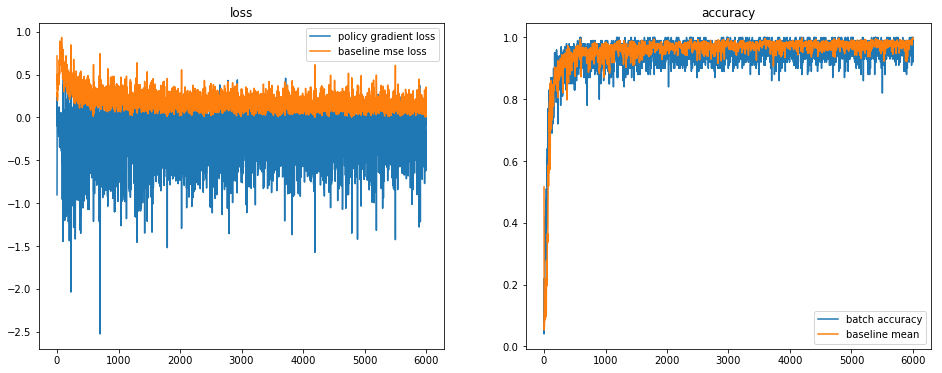

In [9]:
npstats = np.array(stats)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
#plt.plot(npstats[:, 0])
plt.plot(npstats[:, 1])
plt.plot(npstats[:, 2])
#plt.legend(['total loss', 'policy gradient loss', 'baseline mse loss'])
plt.legend(['policy gradient loss', 'baseline mse loss'])
plt.title('loss')

plt.subplot(1, 2, 2)
plt.plot(npstats[:, 3])
plt.plot(npstats[:, 4])
plt.legend(['batch accuracy', 'baseline mean'])
#plt.legend(['batch accuracy'])
plt.title('accuracy')

In [10]:
a = np.zeros((x_test.shape[0], 1))
y_pred, baselines = model.predict([x_test, a])
y_pred = np.argmax(y_pred, axis=1)
print(np.mean(y_pred == y_test))

0.9661
